## Python Imports

In [1]:
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np

import time

import os

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.layers as tfl

# import misc

import pandas as pd

import datetime

import glob

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from tensorflow.keras import utils

import keras
from sklearn.model_selection import train_test_split
# from tensorflow.keras.utils import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from keras.utils import np_utils
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Concatenate
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
# import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing import image_dataset_from_directory
# from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

2025-01-01 20:53:55.642113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735793635.661532    3958 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735793635.667567    3958 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-01 20:53:55.687455: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Check ADNI Dataset

### Check for bad members (missing info, etc)

In [13]:
# README: This whole section (Check ADNI Dataset) isn't contributing and could be removed?
adni_images = "/home/mason/ADNI_Dataset/ADNI_IMG_32.5%_x"
image_folder = '/home/mason/ADNI_Dataset/ADNI_IMG_32.5%_x'
csv_file = 'data/ADNI1_Screening_1.5T_6_23_2023.csv'

data = pd.read_csv(csv_file)

all_pngs = misc.list_files(image_folder, 'png')['all_file_paths']
missing_or_damaged_png_ids = []
images = []
for index, row in data.iterrows():
    image_path = []
    for filepath in all_pngs:
        if (row['Image Data ID'] + '') in filepath:
            image_path.append(filepath)
            break
    if not image_path:  # Check if image_path is empty
        continue  # Skip the current iteration
    image_path = image_path[0]
    try:
        Image.open(image_path)
    except:
        missing_or_damaged_png_ids.append(image_path.split('__')[1])
        all_pngs.remove(image_path)
        continue
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    images.append(image)

for i in missing_or_damaged_png_ids:
    data.drop(data[data['Image Data ID'] == i].index, inplace=True)
    
images = np.array(images)
images = images / 255.0

data['Image'] = list(images)
labels = data["Group"]

FileNotFoundError: [Errno 2] No such file or directory: 'data/ADNI1_Screening_1.5T_6_23_2023.csv'

### Visualize Images

In [ ]:
fig = plt.figure(figsize = (16,9))
for i in range(5):
    ax = fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
    ax.imshow((images[i].astype(np.uint8)))
    plt.imshow(images[i])
    plt.title(f"{i}")

## Declare Base VGG Model

### Declare Datasets

In [2]:
BATCH_SIZE = 315
IMG_SIZE = (224, 224)
directory = "/home/mason/ADNI_Dataset/ADNI_IMG_32.5%_x_organized"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=20,
                                             label_mode = 'categorical')
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=20,
                                             label_mode = 'categorical')

Found 2182 files belonging to 3 classes.
Using 1746 files for training.


Found 2182 files belonging to 3 classes.
Using 436 files for validation.


W0000 00:00:1735793675.692142    3958 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Declare VGG Base

In [3]:
# Load the VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

### Declare VGG Top

In [4]:
# Freeze the base model to retain pretrained weights during training
base_model.trainable = False

# Add a top for 3-way classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling layer
# x = Dropout(0.1)(x)              # Dropout for regularization
x = Dense(512, activation='relu')(x)  # Fully connected layer
# x = Dropout(0.1)(x)              # Dropout for regularization
x = Dense(512, activation='relu')(x)  # Fully connected layer
# x = Dropout(0.1)(x)              # Dropout for regularization
x = Dense(256, activation='relu')(x)  # Fully connected layer
# x = Dropout(0.1)(x)              # Dropout for regularization

predictions = Dense(3, activation='softmax')(x)  # Final output layer with 3 classes

### Combine Base & Top for Complete Model

In [5]:
# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [6]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 15,372,099 (58.64 MB)

 Trainable params: 657,411 (2.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
# Early stopping to prevent redundant training.
early_stopping = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - accuracy: 0.3455 - loss: 3.7192 - val_accuracy: 0.3119 - val_loss: 1.3481
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.3121 - loss: 1.4871 - val_accuracy: 0.3372 - val_loss: 1.4835
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.4104 - loss: 1.3234 - val_accuracy: 0.2339 - val_loss: 1.2065
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.3467 - loss: 1.1147 - val_accuracy: 0.4839 - val_loss: 1.0912
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.5098 - loss: 1.0315 - val_accuracy: 0.4450 - val_loss: 1.0520
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.5386 - loss: 0.9951 - val_accuracy: 0.5229 - val_loss: 1.0006
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.5586 - loss: 0.9481 - val_accuracy: 0.5252 - val_loss: 0.9930
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.5874 - loss: 0.9186 - val_accuracy: 0.5298 - val_loss: 0.9709
Epoch 9/

It was the dropout the whole time????!???!??!??!?

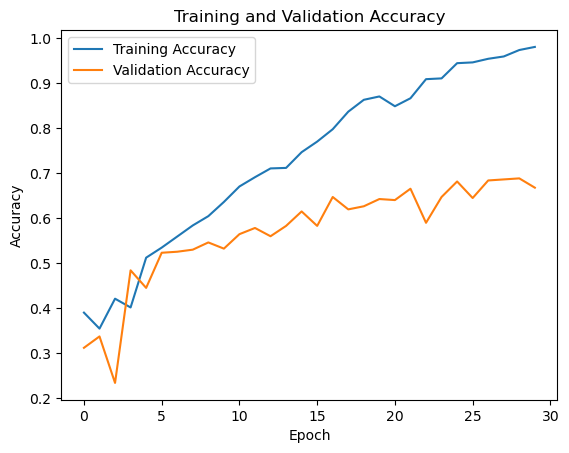

In [8]:
# Get training and validation accuracy and loss from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

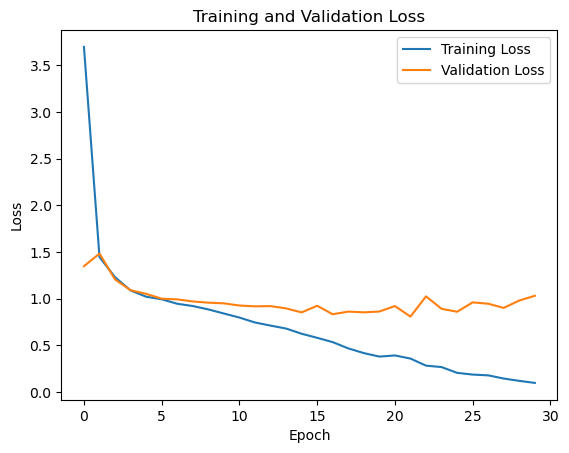

In [9]:
# Plot training and validation loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [10]:
# Get the final accuracy and loss for the last epoch
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Print the final accuracy and loss
print("Final Training Accuracy:", final_train_acc)
print("Final Validation Accuracy:", final_val_acc)
print("Final Training Loss:", final_train_loss)
print("Final Validation Loss:", final_val_loss)

Final Training Accuracy: 0.979954183101654
Final Validation Accuracy: 0.6674311757087708
Final Training Loss: 0.0986839234828949
Final Validation Loss: 1.0313771963119507
